In [2]:
# Imports
import matplotlib.pyplot as plt
import pandas as pd
import time
import numpy as np
import gc
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
from torch.nn import functional as F
from torch.nn import ModuleList
from sklearn.model_selection import KFold
import pickle
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import math
import time
import kmodels as kmk
import ast
import os
from copy import deepcopy
import dill
from matplotlib import cm


os.chdir('/blue/joel.harley/kalynkearney/TL_LateralPinch/LSTM_wGlobal_072123')

In [3]:
# Functions & Classes
def roundup(x, nearest = 5):
    return int(math.ceil(x / nearest)) * nearest

def rounddown(x, nearest = 5):
    return int(math.floor(x / nearest)) * nearest

def split_df_into_subjects(df):
    subject_names = df['Subject'].unique()
    return [df[df['Subject'] == subject] for subject in subject_names]

def split_subject_df(subject_df):
    # get the time column for the subject
    time = subject_df['Time'].values
    # get the indices where the time resets to its minimum value
    time_splits = np.where(time == time.min())[0]
    # split the subject index into events
    subject_events = np.split(subject_df.index, time_splits)
    # get rid of the empty lists in the list of lists
    subject_events = [i for i in subject_events if len(i) > 0]
    # return the list of events
    return [subject_df.loc[event] for event in subject_events]

def sliding_event_df(event_df, window_size, stride):
    # get the number of rows in the event
    num_rows = event_df.shape[0]
    # get the number of windows in the event
    num_windows = (num_rows - window_size) // stride + 1
    # get the indices of the windows
    window_indices = [np.arange(i, i + window_size) for i in range(0, num_windows * stride, stride)]
    # return the list of windows
    return [event_df.iloc[window] for window in window_indices]

# We are creating a new class 'global_model', which is a PyTorch module (nn.Module).
class global_model(nn.Module):
    
    # Here, we're initializing our class with a pre-trained model (ptmodel), 
    # size of the layers in the model (layer_size), number of layers (n_layers),
    # and the number of global inputs that the model will accept (n_global_inputs).
    def __init__(self, ptmodel, layer_size=5, n_layers=1, n_global_inputs=2, freeze_ptmodel=True, change_layers=1):
        # Call the parent (nn.Module) constructor.
        super(global_model, self).__init__()

        # Set the pre-trained model, the number of global inputs, 
        # and the output dimensionality of the pre-trained model.
        self.ptmodel = deepcopy(ptmodel)
        self.n_global_inputs = n_global_inputs
        self.ptmodel_output_dim = ptmodel.output.out_features
        self.n_ptmodel_layers = len(ptmodel.fcs)
        
        # freeze the ptmodel parameters
        if freeze_ptmodel:
            # first freeze everything
            for child in self.ptmodel.children():
                for param in child.parameters():
                    param.requires_grad = False
            # unfreeze the last "change layers" in self.ptmodel.fcs + self.ptmodel.output.
            # if change_layers == 1, then we only unfreeze the self.ptmodel.output
            # if change_layers > 1, then we start unfreezing layers in self.ptmodel.fcs
            for i in range(change_layers-1):
                layer_number = self.n_ptmodel_layers - i - 1
                layer = self.ptmodel.fcs[layer_number]
                layer_params = layer.parameters()
                for p in layer_params:
                    p.requires_grad = True 
            if change_layers > 0:
                for param in self.ptmodel.output.parameters():
                    param.requires_grad = True
        else:
            for child in self.ptmodel.children():
                for param in child.parameters():
                    param.requires_grad = True
                
        
        # Define the first linear layer which will receive the concatenated 
        # global inputs and the output of the pre-trained model.
        self.input = nn.Linear(n_global_inputs + self.ptmodel_output_dim, layer_size)
        # Define the inner fully connected layers of the model.
        self.fcs = nn.ModuleList([nn.Linear(layer_size, layer_size) for i in range(n_layers)])

        # Define the final output layer which will have the same size 
        # as the output of the pre-trained model.
        self.output = nn.Linear(layer_size, self.ptmodel.output.out_features)
        
        # Get which layers requires grad
        pnames, gradstates = [], []
        for paramname,param in zip(self.ptmodel.state_dict(),self.ptmodel.parameters()):
            pnames.append(paramname)
            gradstates.append(param.requires_grad)
        # Format pnames and gradstates into a dataframe
        grad_df = pd.DataFrame()
        grad_df['PT Model Parameter'] = pnames
        grad_df['Requires Grad'] = gradstates
        self.grad_df = grad_df
        
    
    # Define the forward pass of the model.
    def forward(self, x_ptmodel, x_global):
        rows = x_ptmodel.shape[0]
        # Reshape x_global to ensure it is a 2D tensor.
        x_global = x_global.reshape(x_global.shape[0], -1)


        # Feed x_ptmodel into the pre-trained model and store the output.
        #x_ptmodel = self.ptmodel(x_ptmodel)
        # pass the ptmodel.lstm
        x_ptmodel, (h, c) = self.ptmodel.lstm(x_ptmodel)
        x_ptmodel = x_ptmodel.reshape(rows, -1)
        # pass the ptmodel.fc
        for fc in self.ptmodel.fcs:
            x_ptmodel = F.relu(fc(x_ptmodel))
        
        x_ptmodel = self.ptmodel.output(x_ptmodel)
        
        # Concatenate the output of the pre-trained model with the global inputs.
        x = torch.cat((x_ptmodel, x_global), dim=1)
        # Apply the first layer (input) to x and then apply a ReLU activation function.
        x = F.relu(self.input(x))

        # For each fully connected layer, apply the layer to x and 
        # then apply a ReLU activation function.
        for i, fc in enumerate(self.fcs):
            x = F.relu(fc(x))

        # Apply the output layer to x.
        x = self.output(x)

        # Return the output of the model.
        return x

    # Define a function to return the output of the pre-trained model.
    def get_ptmodel_output(self, x_ptmodel):
        # Feed x_ptmodel into the pre-trained model and return the output.
        return self.ptmodel(x_ptmodel)


class Dataset_exp_LSTM(torch.utils.data.Dataset):
    def __init__(self, df, window_size=300, stride=300, xcols=['BIC', 'BRD', 'TRI', 'BRA', 'Time'], ycols=['Mz'], sort_column=['Event', 'Subject']):
        self.df = df
        self.xcols = xcols
        self.ycols = ycols
        self.window_size = window_size
        self.stride = stride
        
        self.df = self.df.sort_values(by=sort_column)
        self.df = self.df.reset_index(drop=True)
        self.subject_index = [i.values for i in self.df.groupby(sort_column).apply(lambda x: x.index)]
        self.subjects = list(self.df.groupby(sort_column).groups.keys())
        self.n_features = len(xcols)
        
        self.subject_events = []
        time_splits = []
        for subject in self.subject_index:
            time = self.df.loc[subject]['Time'].values
            time_splits.append(np.where(time == time.min())[0])
            self.subject_events.append(np.split(subject, time_splits[-1]))
        
        self.df = pd.concat([pd.concat([self.df.loc[subject] for subject in event]) for event in self.subject_events])
        self.df = self.df.reset_index(drop=True)
        
        self.subject_events = []
        time_splits = []
        for subject in self.subject_index:
            time = self.df.loc[subject]['Time'].values
            time_splits.append(np.where(time == time.min())[0])
            self.subject_events.append(np.split(subject, time_splits[-1]))
        self.subject_events = [[i for i in subject if len(i) > 0][0] for subject in self.subject_events]
        self.time_splits = time_splits
        
        self.subject_windows = []
        for subject in self.subject_events:
            n_windows = (len(subject) - self.window_size) // self.stride + 1
            self.subject_windows.append([subject[i*self.stride:i*self.stride+self.window_size] for i in range(n_windows)])
        self.n_windows = n_windows
        self.subject_windows = [[i for i in subject if len(i) > 0] for subject in self.subject_windows]
        self.subject_windows = [i for subject in self.subject_windows for i in subject]
        
        self.X = np.array([self.df.loc[window][self.xcols].values for window in self.subject_windows])
        self.X = self.X.reshape(-1, self.window_size, self.n_features)
        self.X = torch.from_numpy(self.X).float()
        
        self.Y = []
        for window in self.subject_windows:
            forces = np.array([self.df.loc[window][force].values for force in self.ycols])
            forces = forces.flatten()
            self.Y.append(forces)
        
        self.Y = np.array(self.Y)
        self.Y = self.Y.reshape(-1, self.X.shape[1] * len(self.ycols))
        self.Y = torch.from_numpy(self.Y).float()
        
        self.X = self.X.to('cuda')
        self.Y = self.Y.to('cuda')



class Dataset_sim_LSTM(torch.utils.data.Dataset):
    def __init__(self, df, window_size = 100, stride = 100, xcols = ['BIC', 'BRD', 'TRI', 'BRA','Time'], ycols = ['Mz'], sort_column=['Event', 'Subject']):
        self.df = df
        self.xcols = xcols
        self.ycols = ycols
        self.window_size = window_size
        self.stride = stride
        
        # get the subjects from the dataframe
        subjects = split_df_into_subjects(df)
        subject_events = [split_subject_df(subject) for subject in subjects]
        # for each event create a sliding window using the window size and stride
        subject_event_windows = [[sliding_event_df(event, window_size, stride) for event in subject] for subject in subject_events]
        # flatten the list of lists
        subject_event_windows = [window for subject in subject_event_windows for event in subject for window in event]
        self.x_windows = [window[xcols].values for window in subject_event_windows]
        self.y_windows = [window[ycols].values for window in subject_event_windows]
        # save X for an LSTM model. the X shape should be (num_windows, window_size, num_features)
        self.X = np.array([np.expand_dims(x, axis=0) for x in self.x_windows])
        self.X = self.X.reshape(self.X.shape[0], self.X.shape[2], self.X.shape[3])
        self.X = torch.from_numpy(self.X).float()
        self.X = self.X.to('cuda')
        # save Y for an LSTM model. the Y shape should be (num_windows, window_size, num_features)
        self.Y = np.array([np.expand_dims(y, axis=0) for y in self.y_windows])
        self.Y = self.Y.reshape(self.Y.shape[0], self.Y.shape[2], self.Y.shape[3])
        self.Y  = torch.from_numpy(self.Y).float()
        self.Y = self.Y.to('cuda')
        # save the number of windows
        self.num_windows = self.X.shape[0]
        # save the number of features
        self.num_features = self.X.shape[2]
        # save the number of outputs
        self.num_outputs = self.Y.shape[2]
        # save all the variables we used to the class
        self.subjects = subjects
        self.subject_events = subject_events
        self.subject_event_windows = subject_event_windows
        self.sort_column = sort_column
    
    def __len__(self):
        return self.num_windows
    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]
   
def run_Pytorch(model, X_train, Y_train, n_epochs=100, learning_rate=1e-5, batch_size=int(1e5), device='cuda', optimizer=None):
    
    torch.cuda.empty_cache()
    if optimizer is None:
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=0.001)
    losses = train_pytorch(model, 
                 X_train, 
                 Y_train,
                 n_epochs=n_epochs,
                 batch_size=batch_size, 
                 learning_rate=learning_rate)
    return losses

def run_epochs(model, X_train, Y_train, loss_func, optimizer, batches, n_epochs=100, device='cuda'):
    t1 = time.time()
    losses = []
    for epoch in range(n_epochs):
        for i in batches:
           # i = indicies[i]
            optimizer.zero_grad()   # clear gradients for next train
            x = X_train[i,:].to(device)
            y = Y_train[i,:].to(device).flatten()
            pred = model(x).flatten()
            # check if y and pred are the same shape
            if y.shape != pred.shape:
                print('y and pred are not the same shape')
                print(y.shape, pred.shape)
                break
            loss = loss_func(pred, y) # must be (1. nn output, 2. target)
            loss.backward()         # backpropagation, compute gradients
            optimizer.step()        # apply gradients
        losses.append(loss)
        torch.cuda.empty_cache()
        gc.collect()
        if epoch%10 == 0:
            t2 = time.time()
            print('EPOCH : ', epoch,', dt: ',
                  t2 - t1, 'seconds, losses :', 
                  float(loss.detach().cpu())) 
            t1 = time.time()
    return losses


def train_pytorch(model, X_train, Y_train, n_epochs=1000, batch_size=int(1e3), learning_rate=1e-3, device='cuda', optimizer=None):
    if optimizer is None:
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=0.001)
    losses = []
    batches = batch_data(X_train, batch_size)
    model = model.to(device)
    #optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
    loss_func = torch.nn.MSELoss()
    losses = run_epochs(model, X_train, Y_train, loss_func, optimizer, batches, n_epochs=n_epochs)
    return [i.detach().cpu() for i in losses]

def batch_data(Y, batch_size):
    batch_size = int(batch_size)
    n_observations = int(Y.shape[0])
    batch_index = np.arange(0, n_observations, batch_size)
    #np.random.shuffle(batch_index)
    batches = np.array([np.arange(batch_index[i], batch_index[i+1]) \
                   for i in range(len(batch_index)-1)])
    shape = batches.shape
    temp = batches.reshape(-1,1)
    np.random.shuffle(temp)
    batches = temp.reshape(shape[0], shape[1])
    np.random.shuffle(batches)
    n_batches = len(batches)
    return batches

# lets make a randomizer to see if we can get a better model
# function that returns a dictionary of random parameters
def get_random_params(layers=[2, 10], layer_size=[10, 100], learning_rate=[0.000001, 0.01], weight_decay=[0.0001, 0.1], hidden_size = [2,50], change_layers = []):
    params = {}
    if len(layers) == 1:
        params['layers'] = layers[0]
    else:
        params['layers'] = np.random.randint(layers[0], layers[1])
    if len(layer_size) == 1:
        params['layer_size'] = layer_size[0]
    else:
        params['layer_size'] = np.random.randint(layer_size[0], layer_size[1])
    if len(hidden_size) == 1:
        params['hidden_size'] = hidden_size[0]
    else:
        params['hidden_size'] = np.random.randint(hidden_size[0], hidden_size[1])
    if change_layers:
        params['change_layers'] = np.random.randint(change_layers[0], change_layers[1]+1)
        
        
        
    params['learning_rate'] = np.random.uniform(learning_rate[0], learning_rate[1])
    params['weight_decay'] = np.random.uniform(weight_decay[0], weight_decay[1])
   
    return params


def get_model(params):
    model = lstm(n_inputs=8, hidden_size=30, n_outputs=600, n_linear_layers=1, 
                 layer_size=10, lstm_n_outputs=30)
    lr = params['learning_rate']
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=params['weight_decay'])
    return model, optimizer


# create a cv function
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

def get_cv_models_lstm(df, xcols, ycols, n_splits=5, random_state=None, n_inputs=8, hidden_size=30, n_outputs=600, n_linear_layers=[1,5], 
                 layer_size=[10,100], lstm_n_outputs=30, learning_rate=[0.000001, 0.01], weight_decay=[0.0001, 0.1], device='cuda', n_epochs=100,params=None, batch_size = 2048):
    
    # split the data into train and test
    subjects = df['Subject'].unique()
    kf = KFold(n_splits=n_splits, random_state=random_state, shuffle=False)
    results = []
    if params is None:
        params = get_random_params(n_linear_layers=n_linear_layers, layer_size=layer_size, learning_rate=learning_rate, weight_decay=weight_decay)
    for train_index, test_index in kf.split(subjects):
        print(f"Training on {len(train_index)} subjects and testing on {len(test_index)} subjects")
        
        # get the train and test data
        train_df = df[~df['Subject'].isin(subjects[test_index])]
        test_df = df[df['Subject'].isin(subjects[test_index])]
        X_train = train_df[xcols].values
        Y_train = train_df[ycols].values
        X_test = test_df[xcols].values
        Y_test = test_df[ycols].values
        
        # convert to torch float tensors
        X_train = torch.from_numpy(X_train).float().to(device)
        Y_train = torch.from_numpy(Y_train).float().to(device)
        X_test = torch.from_numpy(X_test).float().to(device)
        Y_test = torch.from_numpy(Y_test).float()
        
        # get the model and optimizer
        model, optimizer = get_model(params)
        
        # train the model
        losses = run_Pytorch(model, X_train, Y_train, n_epochs=n_epochs, learning_rate=params['learning_rate'], batch_size=batch_size, optimizer=optimizer, device=device)
        
        # predict on the test data
        pred = model(X_test).detach().cpu().numpy()
        
        # get the statistics
        mse = mean_squared_error(Y_test, pred)
        mae = mean_absolute_error(Y_test, pred)
        r2 = r2_score(Y_test, pred)
        
        # append the model and statistics to the list
        results.append({'model': model, 'mse': mse, 'r2': r2, 'mae': mae, 'params': params})
        
    # print the average statistics
    avg_mse = np.mean([result['mse'] for result in results])
    avg_r2 = np.mean([result['r2'] for result in results])
    avg_mae = np.mean([result['mae'] for result in results])
    
    # pretty print the results
    print(f"Average Mean Squared Error: {avg_mse:.2f}")
    print(f"Average R2 Score: {avg_r2:.2f}")
    print(f"Average Mean Absolute Error: {avg_mae:.2f}")
    
    # print the params 
    print(f"Params: {params}")
    return results

# make a function to create a random search for model params

def random_search(df, xcols, ycols, outpath, n_splits=5, random_state=None, n_linear_layers=[2, 10], layer_size=[4, 100], hidden_size = 30,
                  learning_rate=[0.000001, 0.01], weight_decay=[0.0001, 0.1], device='cuda', n_epochs=100, n_iter=10, batch_size=2048, lstm_n_outputs=3000):
    # create a list to store the results
    results = []
    avg_results = []
    n_inputs = len(xcols)
    n_outputs = len(ycols)
    for i in range(n_iter):
        # get the cv models
        cv_results = get_cv_models_lstm(df, xcols, ycols, n_splits=n_splits, random_state=random_state, n_inputs=n_inputs, hidden_size=hidden_size, n_outputs=n_outputs, n_linear_layers=n_linear_layers, 
                 layer_size=layer_size, lstm_n_outputs=lstm_n_outputs, learning_rate=learning_rate, weight_decay=weight_decay, device=device, n_epochs=100,params=params, batch_size = batch_size)
                    
        # append the results
        results.append(cv_results)
        avg_result = {'mse':np.mean([model['mse'] for model in cv_results]), 
                       'r2': np.mean([model['r2'] for model in cv_results]), 
                       'mae': np.mean([model['mae'] for model in cv_results])}
        avg_results.append(avg_result)
        
        # save the model architecture and parameters
        statsdf = pd.DataFrame(cv_results)
        statsdf.to_csv(outpath, mode='a', index=False, header=False)
    
    # print the best model
    # result df 
    df = pd.DataFrame(avg_results)
    
    # get the best  model 
    best_model = results[np.argmin(df['mse'])][0]
    best_avg_results = avg_results[np.argmin(df['mse'])]
    best_params = best_model['params']
    
    print(f"Best Model: {best_model}")
    print(f"Best Average Results: {best_avg_results}")
    
    return results, best_model, best_avg_results, best_params

    
# Plot the prediction of the model on a event dataframe from the dataclass 
def get_event_prediction(event_df, model, window_size = 300, stride=5, xcols = ['BIC', 'BRD', 'TRI', 'BRA', 'Time'], ycols = ['Mz'], device='cuda'):
    # get the number of rows in the event
    num_rows = event_df.shape[0]
    window_dfs = sliding_event_df(event_df, window_size = num_rows, stride = 1)
    # get the X and Y values for the event
    X = np.array([window[xcols].values for window in window_dfs])
    Y = np.array([window[ycols].values for window in window_dfs])
    # reshape the X and Y values for the model
    X = np.expand_dims(X, axis=0)
    X = X.reshape(X.shape[0], X.shape[2], X.shape[3])
    Y = np.expand_dims(Y, axis=0)
    Y = Y.reshape(Y.shape[0], Y.shape[2], Y.shape[3])
    # get the prediction from the model
    Y_pred = model(torch.tensor(X, dtype=torch.float32).to(device))
    # get the prediction and actual values from the tensors
    Y_pred = Y_pred.detach().cpu().numpy()
    # knowing the stride we know that the prediction is every stride number of rows
    # lets make a list of indexs to keep track of which windows belond to which time points
    window_indices = [i.index for i in window_dfs]
    # go into each window indicies and append the predicitnos to each dataframe Fx_pred, Fy_pred, Fz_pred
    window_dfs = [window_dfs[i].assign(Fx_pred = Y_pred[0][i][0], Fy_pred = Y_pred[0][i][1], Fz_pred = Y_pred[0][i][2]) for i in range(len(window_dfs))]
    window_merged = pd.concat(window_dfs)
    # take the mean of each index using the window indices
    event_df = window_merged.groupby(window_merged.index).mean()
    return window_dfs

def batch_predict(model, input, batch_size=500):
    n_batches = int(np.ceil(input.shape[0] / batch_size))
    for i in range(n_batches):
        gc.collect()
        torch.cuda.empty_cache()
        if i == 0:
            output = model(input[i*batch_size:(i+1)*batch_size]).detach().cpu()
        else:
            output = torch.cat((output, model(input[i*batch_size:(i+1)*batch_size]).detach().cpu())).detach().cpu()
    return output

def TLLSTM(model, X, change_layers=1, unfreeze_lstm=False):
    n_inputs = model.lstm.input_size
    new = lstm(n_linear_layers=model.n_linear_layers, n_outputs=model.output.out_features, layer_size=model.layer_size, hidden_size = model.hidden_size, n_inputs = n_inputs)
    test = new(X)
    new.load_state_dict(model.state_dict())
    children = [child for child in new.children()]
    for child in children:
        for param in child.parameters():
            param.requires_grad = False
    total_layers = len(children)
    for i in range(change_layers):
        layer = children[total_layers-i-1]
        layer_params = layer.parameters()
        for p in layer_params:
            p.requires_grad = True
    if unfreeze_lstm == True:
        new.unfreeze_lstm()
    return new

class lstm(nn.Module):
    def __init__(self, n_inputs=5, hidden_size=24, n_outputs=612, n_linear_layers=1, 
                 layer_size=10, seq_len = 204):
        super().__init__()
        self.lstm = nn.LSTM(n_inputs, hidden_size, batch_first=True)
        self.fcs = nn.ModuleList([nn.Linear(layer_size, layer_size) for i in range(n_linear_layers)])
        self.fcs[0] = nn.Linear(hidden_size*seq_len, layer_size)
        self.layer_size = layer_size
        self.hidden_size = hidden_size
        self.n_linear_layers = n_linear_layers 
        self.output = nn.Linear(layer_size, n_outputs)
        
    def forward(self, x):
        
        rows = x.shape[0]
        
        # passes data through LSTM layers
        x, _ = self.lstm(x)
        x = x.reshape(rows, -1)
        
        # Passes data through linear layers
        for i, fc in enumerate(self.fcs):
            x = F.relu(fc(x))
        x = self.output(x)
        return x
    
    def unfreeze_lstm(self):
        lstm_children = self.lstm.children()
        for child in lstm_children:
            for param in child.parameters():
                param.requires_grad = True
                
def run_Pytorch_global(model, X_train, X_global, Y_train, n_epochs=100, learning_rate=1e-5, batch_size=int(1e5), device='cuda', optimizer=None):
    
    torch.cuda.empty_cache()
    if optimizer is None:
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=0.001)
    losses = train_pytorch_global(model, 
                 X_train, 
                 X_global,
                 Y_train,
                 n_epochs=n_epochs,
                 batch_size=batch_size, 
                 learning_rate=learning_rate)
    return losses

def run_epochs_global(model, X_train, X_global, Y_train, loss_func, optimizer, batches, n_epochs=100, device='cuda'):
    import time
    t1 = time.time()
    losses = []
    for epoch in range(n_epochs):
        for i in batches:
           # i = indicies[i]
            optimizer.zero_grad()   # clear gradients for next train
            x = X_train[i,:].to(device)
            x_global = X_global[i,:].to(device)
            y = Y_train[i,:].to(device).flatten()
            pred = model(x, x_global).flatten()
            # check if y and pred are the same shape
            if y.shape != pred.shape:
                print('y and pred are not the same shape')
                print(y.shape, pred.shape)
                break
            loss = loss_func(pred, y) # must be (1. nn output, 2. target)
            loss.backward()         # backpropagation, compute gradients
            optimizer.step()        # apply gradients
        losses.append(loss)
        torch.cuda.empty_cache()
        gc.collect()
        if epoch%10 == 0:
            t2 = time.time()
            print('EPOCH : ', epoch,', dt: ',
                  t2 - t1, 'seconds, losses :', 
                  float(loss.detach().cpu())) 
            t1 = time.time()
    return losses


def train_pytorch_global(model, X_train, X_global, Y_train, n_epochs=1000, batch_size=int(1e3), learning_rate=1e-3, device='cuda', optimizer=None):
    if optimizer is None:
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=0.001)
    losses = []
    batches = batch_data(X_train, batch_size)
    model = model.to(device)
    #optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
    loss_func = torch.nn.MSELoss()
    losses = run_epochs_global(model, X_train, X_global, Y_train, loss_func, optimizer, batches, n_epochs=n_epochs)
    return [i.detach().cpu() for i in losses]


# Import & Format Simulation Data

In [4]:
# Import 
df = pd.read_pickle('LP_Simulations_Formatted.pkl')
df['Event'] = np.nan

df


,Time,FCU,EPL,EPB,FPL,APL,FPB,OPP,Fx,Fy,Fz,ADD,Subject,Event
0,0.000000,0.054566,0.058537,0.062743,0.155728,0.023906,0.021142,0.070465,-9.259692,-4.447818,-6.536988,0.026819,6.26_0.9_1.06,NaN
1,0.009799,0.054646,0.058400,0.062911,0.154414,0.023787,0.021018,0.077124,-9.502468,-4.600985,-6.520491,0.026349,6.26_0.9_1.06,NaN
2,0.019599,0.054800,0.057753,0.062681,0.153220,0.023763,0.021220,0.095268,-9.513043,-4.624847,-6.518658,0.026434,6.26_0.9_1.06,NaN
3,0.029398,0.056122,0.056917,0.063201,0.157919,0.023762,0.022113,0.114959,-9.409544,-4.564386,-6.497891,0.026648,6.26_0.9_1.06,NaN
4,0.039197,0.057602,0.056416,0.063981,0.163014,0.023785,0.023148,0.126942,-9.251525,-4.474644,-6.437751,0.026858,6.26_0.9_1.06,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1345171,1.950067,0.077327,0.028705,0.070763,0.186818,0.081797,0.022118,0.090759,-4.916051,-5.716611,-12.003086,0.024750,6.53_1.04_1.02,NaN
1345172,1.959866,0.077751,0.027808,0.071065,0.191791,0.082448,0.022103,0.095652,-5.248973,-5.937422,-12.067884,0.024120,6.53_1.04_1.02,NaN
1345173,1.969666,0.078584,0.027024,0.071566,0.193814,0.083229,0.022089,0.093776,-5.556444,-6.157407,-12.143441,0.023570,6.53_1.04_1.02,NaN
1345174,1.979465,0.078977,0.026315,0.071994,0.195077,0.083762,0.022077,0.086941,-5.809779,-6.380327,-12.206728,0.023072,6.53_1.04_1.02,NaN


In [5]:
# Sanity check: Look at summary of data, as imported
df.describe()

,Time,FCU,EPL,EPB,FPL,APL,FPB,OPP,Fx,Fy,Fz,ADD,Event
count,1.345176e+06,1.345176e+06,1.345176e+06,1.345176e+06,1.345176e+06,1.345176e+06,1.345176e+06,1.345176e+06,1.345176e+06,1.345176e+06,1.345176e+06,1.345176e+06,0.0
mean,9.946321e-01,8.115177e-02,5.573487e-02,1.026697e-01,2.800349e-01,2.560354e-02,2.210484e-02,9.700766e-02,-1.471004e+01,-1.108023e+01,-4.609680e+00,3.493938e-02,NaN
std,5.770732e-01,3.876185e-02,6.389191e-02,9.390833e-02,1.779783e-01,1.711555e-02,4.534242e-03,3.413028e-02,1.147224e+01,8.370552e+00,5.968456e+00,4.680777e-02,NaN
min,0.000000e+00,2.000000e-02,2.000000e-02,2.000000e-02,2.000000e-02,2.000000e-02,2.000000e-02,2.361651e-02,-9.194416e+01,-4.886047e+01,-2.529159e+01,2.000000e-02,NaN
25%,4.973161e-01,4.858133e-02,2.690397e-02,4.017638e-02,1.420866e-01,2.000000e-02,2.014538e-02,7.450201e-02,-1.982975e+01,-1.626055e+01,-7.464714e+00,2.007790e-02,NaN
50%,9.946321e-01,7.625018e-02,3.557513e-02,7.419687e-02,2.516580e-01,2.200024e-02,2.109311e-02,9.145547e-02,-1.181543e+01,-9.139811e+00,-5.817150e+00,2.220208e-02,NaN
75%,1.491948e+00,1.103375e-01,5.729837e-02,1.309355e-01,4.021168e-01,2.428082e-02,2.207121e-02,1.112851e-01,-6.994484e+00,-4.549752e+00,-4.062083e+00,2.869113e-02,NaN
max,1.989264e+00,5.452957e-01,8.150781e-01,9.236893e-01,8.376618e-01,2.624285e-01,2.474382e-01,6.932364e-01,1.818547e+01,1.090554e+01,3.753200e+01,6.654979e-01,NaN


In [6]:
# Define ml model inputs and outputs, as well length of trials
xcols = ['EPB', 'EPL', 'FPL', 'APL', 'ADD', 'FCU', 'FPB', 'OPP', 'Time']
ycols = ['Fx','Fy','Fz']
simlength = 204 # Number of time points per trial

In [7]:
# Incorporate an event column, specifying event for each subject and consecutive simlength (starting where time = 0)

new_df = pd.DataFrame()
for subj in df.Subject.unique():
    
    subj_df = df[df['Subject'] == subj]
    
    # Iterate through chunks of simlength
    event = 0
    for i in range(0,subj_df.shape[0],simlength):
        
        chunk = subj_df[i:i+simlength]
        
        # Set event for current chunk to event
        chunk['Event'] = event
        event += 1
        
        # Append to new_df
        new_df = pd.concat([new_df, chunk])


/scratch/local/3637663/ipykernel_122414/899732513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chunk['Event'] = event


In [8]:
# Replace df with new_df
df = new_df
df

,Time,FCU,EPL,EPB,FPL,APL,FPB,OPP,Fx,Fy,Fz,ADD,Subject,Event
0,0.000000,0.054566,0.058537,0.062743,0.155728,0.023906,0.021142,0.070465,-9.259692,-4.447818,-6.536988,0.026819,6.26_0.9_1.06,0
1,0.009799,0.054646,0.058400,0.062911,0.154414,0.023787,0.021018,0.077124,-9.502468,-4.600985,-6.520491,0.026349,6.26_0.9_1.06,0
2,0.019599,0.054800,0.057753,0.062681,0.153220,0.023763,0.021220,0.095268,-9.513043,-4.624847,-6.518658,0.026434,6.26_0.9_1.06,0
3,0.029398,0.056122,0.056917,0.063201,0.157919,0.023762,0.022113,0.114959,-9.409544,-4.564386,-6.497891,0.026648,6.26_0.9_1.06,0
4,0.039197,0.057602,0.056416,0.063981,0.163014,0.023785,0.023148,0.126942,-9.251525,-4.474644,-6.437751,0.026858,6.26_0.9_1.06,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1345171,1.950067,0.077327,0.028705,0.070763,0.186818,0.081797,0.022118,0.090759,-4.916051,-5.716611,-12.003086,0.024750,6.53_1.04_1.02,16
1345172,1.959866,0.077751,0.027808,0.071065,0.191791,0.082448,0.022103,0.095652,-5.248973,-5.937422,-12.067884,0.024120,6.53_1.04_1.02,16
1345173,1.969666,0.078584,0.027024,0.071566,0.193814,0.083229,0.022089,0.093776,-5.556444,-6.157407,-12.143441,0.023570,6.53_1.04_1.02,16
1345174,1.979465,0.078977,0.026315,0.071994,0.195077,0.083762,0.022077,0.086941,-5.809779,-6.380327,-12.206728,0.023072,6.53_1.04_1.02,16


In [9]:
# Standardize inputs(x columns)
scaler = StandardScaler()
df_normalized = df.copy()
X = df_normalized[xcols].values
X = scaler.fit_transform(X)
df_normalized[xcols] = X

In [10]:
# Set stride and window size
window_size = simlength
stride = 1

window_size_test= simlength
stride_test= 1

In [11]:
# Grab a leave out "subject" randomly from df_normalized. As this is the large sim data, we just want a few leave out samples to test
allsubjs = df_normalized['Subject'].unique()
np.randomseed = 0
leave_out_subj = np.random.choice(allsubjs, 10, replace=False)

print(f"Leaving out subjects {leave_out_subj}")

Leaving out subjects ['8.29_0.89_1.02' '3.76_0.94_0.95' '6.56_0.96_1.03' '8.06_1.02_0.95'
 '8.34_1.05_0.98' '8.44_0.99_0.88' '3.94_1.04_1.03' '3.99_0.99_1.06'
 '3.75_1.04_0.98' '9.12_0.94_1.05']


In [12]:
# Organize the data, grouping subject IDs together# Define train and test set 
leave_out_df = df_normalized[df_normalized['Subject'].isin(leave_out_subj)]
leave_out = Dataset_exp_LSTM(leave_out_df, window_size=window_size_test, stride=stride_test, xcols = xcols, ycols = ycols, sort_column=['Event', 'Subject'])
print('Size of X for test set: {}'.format(leave_out.X.shape))
print('Size of Y for test set: {}'.format(leave_out.Y.shape))
print('Trials in test set: {} \n'.format(leave_out.X.shape[0]))

train_df = df_normalized[~df_normalized['Subject'].isin(leave_out_subj)]
train = Dataset_exp_LSTM(train_df,  window_size=window_size, stride=stride, xcols = xcols, ycols = ycols, sort_column=['Event', 'Subject'])
print('Size of X for train set: {}'.format(train.X.shape))
print('Size of Y for train set: {}'.format(train.Y.shape))
print('Trials in test set: {} \n'.format(train.X.shape[0]))

print('Subjects in training set: {}'.format(len(train_df['Subject'].unique())))

# Print percent of trials in leave out set and train set, respectively
print('Percent of trials in leave out set: {}'.format(leave_out.X.shape[0]/(leave_out.X.shape[0]+train.X.shape[0])))
print('Percent of trials in train set: {}'.format(train.X.shape[0]/(leave_out.X.shape[0]+train.X.shape[0])))

Size of X for test set: torch.Size([112, 204, 9])
Size of Y for test set: torch.Size([112, 612])
Trials in test set: 112 

Size of X for train set: torch.Size([6482, 204, 9])
Size of Y for train set: torch.Size([6482, 612])
Trials in test set: 6482 

Subjects in training set: 508
Percent of trials in leave out set: 0.016985138004246284
Percent of trials in train set: 0.9830148619957537


A random input:


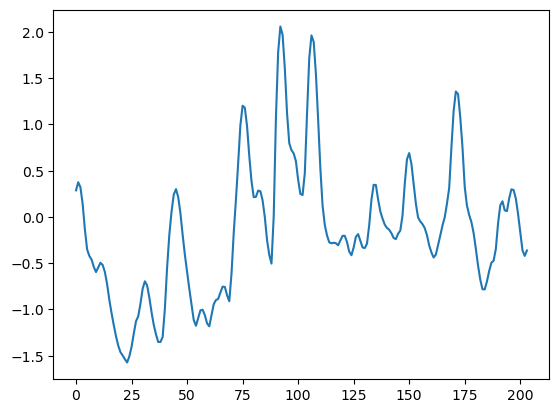

In [13]:
# Sanity check: Plot random X
rand_trial = np.random.randint(0,train.X.shape[0])
rand_feature = np.random.randint(0,train.X.shape[2])

print('A random input:')

plt.plot(train.X[rand_trial,:,rand_feature].detach().cpu().numpy())
plt.show()


A random output:


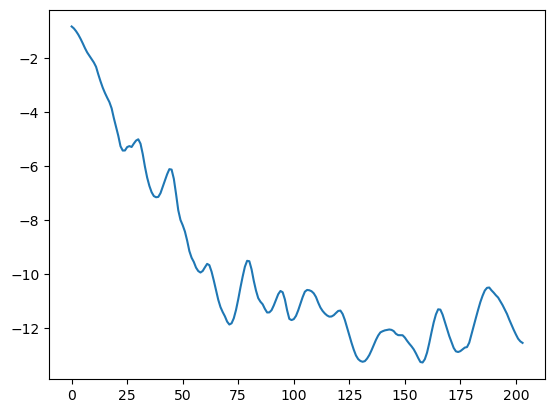

In [14]:
# Sanity check: Plot random Y
print('A random output:')
rand_trial = np.random.randint(0,train.Y.shape[0])

plt.plot(train.Y[rand_trial,0:204].detach().cpu().numpy())

# Define Architecture to Match Parameter Tuning Results (from training on simulations)

In [58]:
# Get params from file containing results of random search

paramfile = 'pretraining_paramtuning_v1.csv'

# Load in results of the random search and select the model params that produced lowest mse
paramtuning = pd.read_csv(paramfile, header = None)
paramtuning.columns = ['model','mse','r2','mae','params']
paramresults = pd.DataFrame()

for mod in paramtuning['model'].unique():
    currparamresults = pd.DataFrame()
    currmod = paramtuning[paramtuning['model']==mod]
    currparamresults['params'] = currmod['params'].unique()    
    currparamresults['avg mse'] = currmod['mse'].mean()
    
    paramresults = pd.concat([paramresults, currparamresults])
    
best = paramresults[paramresults['avg mse'] == min(paramresults['avg mse'])]
best_params = eval(best['params'][0])

print('Lowest validation mse: {} \n Best params: {}'.format(best['avg mse'][0], best_params))

Lowest validation mse: 22.6268212690909 
 Best params: {'layers': 8, 'layer_size': 39, 'hidden_size': 18, 'learning_rate': 0.0007322525774801533, 'weight_decay': 0.04753350122210549}


In [59]:
# Sanity check: See that this model matches old paramtuning results

ptmodel_old_file = 'pretrained_lyr8_lyrsz39_hidsz18_old.pkl'

with open(ptmodel_old_file, 'rb') as f:
    ptmodel_old = pickle.load(f)
    
print('Old model:')
ptmodel_old

FileNotFoundError: [Errno 2] No such file or directory: 'pretrained_lyr8_lyrsz39_hidsz18_old.pkl'

In [60]:
# Get architecture and hyperparameters of old model. 
n_inputs = len(xcols)
hidden_size = ptmodel_old.hidden_size
n_outputs = simlength*len(ycols)
n_linear_layers = ptmodel_old.n_linear_layers
layer_size = ptmodel_old.layer_size

learning_rate = best_params['learning_rate']
weight_decay = best_params['weight_decay']

batch_size = 2040 # Matches batch size used when parameter tuning
n_epochs = 3000
device = 'cuda'

ptmodelname = 'pretraned_lyr{}_lyrsz{}_ep{}_lr{}_071923.pkl'.format(n_linear_layers, layer_size,n_epochs, "{:.0e}".format(learning_rate))
print(f'File name of pre-trained model: {ptmodelname}')

NameError: name 'ptmodel_old' is not defined

In [31]:
# Create lstm and optimizer with the architecture of the old model
device = 'cpu'
ptmodel = lstm(n_inputs=n_inputs, hidden_size=hidden_size, n_outputs=n_outputs, n_linear_layers=n_linear_layers, layer_size=layer_size).to(device)
optimizer = torch.optim.Adam(ptmodel.parameters(), lr=learning_rate, weight_decay=weight_decay)
ptmodel

lstm(
  (lstm): LSTM(9, 18, batch_first=True)
  (fcs): ModuleList(
    (0): Linear(in_features=3672, out_features=39, bias=True)
    (1-7): 7 x Linear(in_features=39, out_features=39, bias=True)
  )
  (output): Linear(in_features=39, out_features=612, bias=True)
)

In [32]:
# Train the model on simulations
device = 'cuda'
X_train = train.X.to(device)
Y_train = train.Y.to(device)

# Print all inputs to train_pytorch
print(f'X_train shape: {X_train.shape}')
print(f'Y_train shape: {Y_train.shape}')
print(f'Pretrained model: {ptmodel}')
print(f'Optimizer: {optimizer}')
print(f'Number of epochs: {n_epochs}')
print(f'Batch size: {batch_size}')
print(f'Learning rate: {learning_rate}')
print(f'Device: {device}')

# Train the model using the data in X_tensor and Y_tensor. Define optimizer w. best params
losses = train_pytorch(ptmodel, X_train, Y_train, batch_size=batch_size, n_epochs=n_epochs, learning_rate= learning_rate,
                         optimizer=optimizer, device=device)

X_train shape: torch.Size([6458, 204, 9])
Y_train shape: torch.Size([6458, 612])
Pretrained model: lstm(
  (lstm): LSTM(9, 18, batch_first=True)
  (fcs): ModuleList(
    (0): Linear(in_features=3672, out_features=39, bias=True)
    (1-7): 7 x Linear(in_features=39, out_features=39, bias=True)
  )
  (output): Linear(in_features=39, out_features=612, bias=True)
)
Optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.0007322525774801533
    maximize: False
    weight_decay: 0.04753350122210549
)
Number of epochs: 3000
Batch size: 2040
Learning rate: 0.0007322525774801533
Device: cuda
EPOCH :  0 , dt:  0.49695348739624023 seconds, losses : 194.18434143066406
EPOCH :  10 , dt:  1.3717281818389893 seconds, losses : 192.28604125976562
EPOCH :  20 , dt:  1.3634884357452393 seconds, losses : 84.76402282714844
EPOCH :  30 , dt:  1.349175214767456 seconds, losses : 2

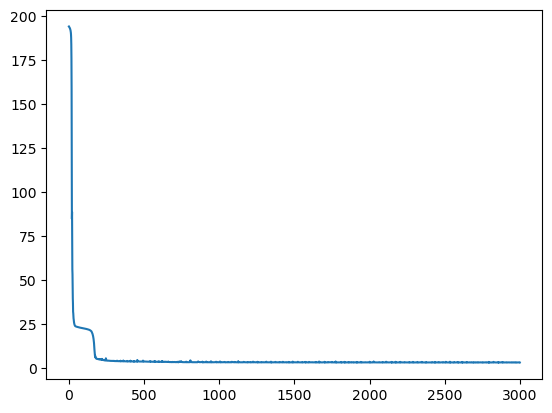

In [33]:
# Vizualize losses
plt.plot(losses)

In [51]:
# Save the pretrained model
with open(ptmodelname, 'wb') as f:
    pickle.dump(ptmodel, f)

# Import & Format Experimental Data

In [15]:
# Import recorded data
df = pd.read_pickle('LP_Recorded_wGlobalFeatures.pkl')

In [16]:
# Define ml model inputs and outputs, as well length of trials
xcols_dynamic = ['EPB', 'EPL', 'FPL', 'APL', 'ADD', 'FCU', 'FPB', 'OPP', 'Time']
xcols_static = ['MVC', 'Sex', 'Height', 'Mass', 'Hand Length', 'Hand Width','Forearm Length', 'Elbow Width']     
xcols = xcols_dynamic + xcols_static
ycols = ['Fx', 'Fy', 'Fz']
simlength = 204 # Number of time points per trial

# Define number of features for static, dynamic, and total (used to format later)
n_features = len(xcols)
n_global_features = len(xcols_static)
n_local_features = len(xcols_dynamic)

df['Sex'] = df.Sex.map({'M': 0, 'F': 1}) # Convert 'Sex' categorical variable to binary

# Randomly select list of subjects for leave out set. Use 20% of subjects for leave out set
all_subjects = df['Subject'].unique()
np.random.seed(50)
leave_out_subj = np.random.choice(all_subjects, int(len(all_subjects)*0.2), replace=False)

print(f'Leave out subjects: {leave_out_subj}')
print(f'Train subjects: {all_subjects[~np.isin(all_subjects, leave_out_subj)]}')

Leave out subjects: ['RGr10' 'NrM10' 'KfC96']
Train subjects: ['Awo46' 'bsC93' 'bXa12' 'hnC72' 'HqQ59' 'IMO98' 'JBL63' 'jGD95' 'JHv15'
 'jWn63' 'KSU55' 'zNu44']


In [17]:
df

,Time,Event,EPB,EPL,FPL,APL,ADD,FCU,FPB,OPP,...,Age,Sex,Height,Mass,Hand Length,Hand Width,Forearm Length,Elbow Width,Upper Arm Length,Handedness
0,0.000000,0,0.489394,0.771289,0.129345,0.546281,0.565945,0.162972,0.425540,0.571402,...,19,0,1.73,72.1,18.0,9.0,25.5,10.5,30.5,87.5
1,0.024629,0,0.490035,0.772143,0.130824,0.555049,0.581721,0.165896,0.437179,0.571402,...,19,0,1.73,72.1,18.0,9.0,25.5,10.5,30.5,87.5
2,0.049258,0,0.490759,0.772514,0.130824,0.563454,0.598187,0.168965,0.441816,0.571402,...,19,0,1.73,72.1,18.0,9.0,25.5,10.5,30.5,87.5
3,0.073887,0,0.491426,0.773356,0.130824,0.571014,0.614853,0.172069,0.441816,0.571402,...,19,0,1.73,72.1,18.0,9.0,25.5,10.5,30.5,87.5
4,0.098516,0,0.492013,0.774301,0.130824,0.572249,0.618547,0.175172,0.441816,0.577253,...,19,0,1.73,72.1,18.0,9.0,25.5,10.5,30.5,87.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
607,4.901151,2,0.258348,0.599492,0.991094,0.845696,0.750183,0.397436,0.701687,0.778256,...,22,1,1.67,60.8,18.0,8.5,25.0,8.5,32.0,100.0
608,4.925780,2,0.255153,0.599492,0.991094,0.845696,0.750183,0.404779,0.701687,0.778256,...,22,1,1.67,60.8,18.0,8.5,25.0,8.5,32.0,100.0
609,4.950409,2,0.251757,0.599492,0.991094,0.845696,0.742197,0.411974,0.701687,0.778256,...,22,1,1.67,60.8,18.0,8.5,25.0,8.5,32.0,100.0
610,4.975038,2,0.248169,0.599492,0.991094,0.845696,0.731769,0.418274,0.701687,0.778256,...,22,1,1.67,60.8,18.0,8.5,25.0,8.5,32.0,100.0


In [18]:
# Standardize inputs(x columns)
scaler = StandardScaler() 
df_normalized = df.copy()

normcols = [x for x in xcols if x != 'Time']
X = df_normalized[normcols].values
X = scaler.fit_transform(X)
df_normalized[normcols] = X

In [19]:
# Set stride and window size
window_size = simlength
stride = 100

window_size_test= simlength
stride_test= 100

In [20]:
# Define train and test set 
leave_out_df = df_normalized[df_normalized['Subject'].isin(leave_out_subj)]
leave_out = Dataset_exp_LSTM(leave_out_df, window_size=window_size_test, stride=stride_test, xcols = xcols, ycols = ycols, sort_column=['Event', 'Subject'])
print('Size of X for test set: {}'.format(leave_out.X.shape))
print('Size of Y for test set: {}'.format(leave_out.Y.shape))
print('Trials in test set: {} \n'.format(leave_out.X.shape[0]))

train_df = df_normalized[~df_normalized['Subject'].isin(leave_out_subj)]
train = Dataset_exp_LSTM(train_df,  window_size=window_size, stride=stride, xcols = xcols, ycols = ycols, sort_column=['Event', 'Subject'])
print('Size of X for train set: {}'.format(train.X.shape))
print('Size of Y for train set: {}'.format(train.Y.shape))
print('Trials in test set: {} \n'.format(train.X.shape[0]))

print('Subject(s) in test set: {}'.format(leave_out_df['Subject'].unique()))
print('Subjects in training set: {}'.format(train_df['Subject'].unique()))

Size of X for test set: torch.Size([9, 204, 17])
Size of Y for test set: torch.Size([9, 612])
Trials in test set: 9 

Size of X for train set: torch.Size([36, 204, 17])
Size of Y for train set: torch.Size([36, 612])
Trials in test set: 36 

Subject(s) in test set: ['KfC96' 'NrM10' 'RGr10']
Subjects in training set: ['Awo46' 'bsC93' 'bXa12' 'hnC72' 'HqQ59' 'IMO98' 'JBL63' 'jGD95' 'JHv15'
 'jWn63' 'KSU55' 'zNu44']


A random input:


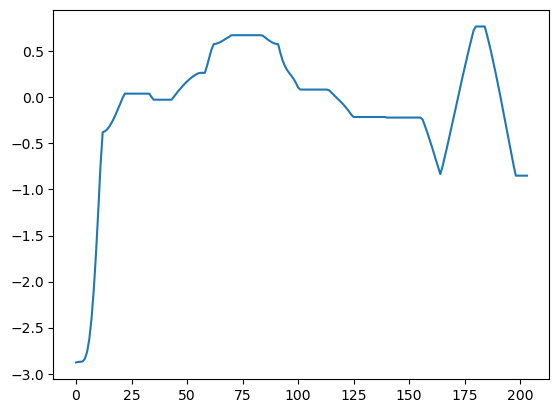

A random output:


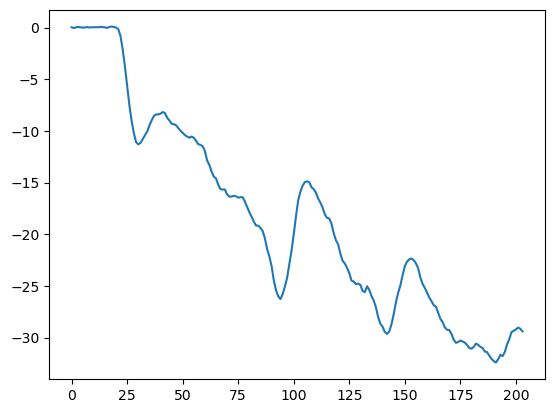

In [22]:
# Sanity check: Plot random trials
rand_trial = np.random.randint(0,train.X.shape[0])
rand_feature = np.random.randint(0,train.X.shape[2])

print('A random input:')

plt.plot(train.X[rand_trial,:,rand_feature].detach().cpu().numpy())
plt.show()
print('A random output:')
rand_trial = np.random.randint(0,train.Y.shape[0])

plt.plot(train.Y[rand_trial,204:408].detach().cpu().numpy())

# Load pre-trained model and incorporate global inputs

In [61]:
# Load the pre-trained  model
ptmodelname = 'pretrained_lyr8_lyrsz39_ep3000_lr7e-04_071823.pkl'
ptfile = ptmodelname

with open(ptfile, 'rb') as f:
    ptmodel = pickle.load(f)
        
ptmodel = ptmodel.to('cpu')

ptmodel

lstm(
  (lstm): LSTM(9, 18, batch_first=True)
  (fcs): ModuleList(
    (0): Linear(in_features=3672, out_features=39, bias=True)
    (1-7): 7 x Linear(in_features=39, out_features=39, bias=True)
  )
  (output): Linear(in_features=39, out_features=612, bias=True)
)

# Parameter Tune the Global Model

In [52]:
# Define parameters for random search. Keep hidden dims what they are
n_layers = [1,3]
layer_size=[1, 30]
learning_rate = [0.000001, 0.01]
weight_decay = [0.0001, 0.1]
change_layers = [0, 2]

# Define other model attributes
device = 'cuda'
n_epochs = 250
n_iter = 25 # Number of set of parameters to try
n_splits = 4 # Number of splits for CV
batch_size = 4

outpath = 'LP_finetuning_paramtuning_071923.csv'

In [53]:
# Parameter tuning
results = []
avg_results = []

stopcheck = 0
# For each set of parameters
for i in range(n_iter):
    
    # Get random parameters. Don't use all the parameters, just LR and weight_decay
    params = get_random_params(learning_rate=learning_rate, weight_decay = weight_decay, layers = n_layers, layer_size = layer_size, change_layers = change_layers)
    lr = params['learning_rate']
    wd = params['weight_decay']
    lyr = params['layers']
    lyrsz = params['layer_size']
    hiddensz = params['hidden_size']
    chglyr = params['change_layers']
    print(params)
    
    # split the data into train and test
    subjects = train_df['Subject'].unique()
    kf = KFold(n_splits=n_splits, shuffle=False)
    results = []
    
    # Store results for CV
    cv_results = []
    
    # For each k fold 
    for train_index, test_index in kf.split(subjects):
        
        # get the train and test data
        currtrain = Dataset_exp_LSTM(train_df[~train_df['Subject'].isin(subjects[test_index])], window_size=window_size, stride=stride, xcols = xcols, ycols = ycols)
        currtest = Dataset_exp_LSTM(train_df[train_df['Subject'].isin(subjects[test_index])], window_size=window_size, stride=stride, xcols = xcols, ycols = ycols)
        currX_train_local = currtrain.X[:,:,:n_local_features].to(device)
        currX_train_global = currtrain.X[:,:,n_local_features:].to(device)[:,0,:]
        currY_train = currtrain.Y.to(device)
        currX_test_local = currtest.X[:,:,:n_local_features].to(device)
        currX_test_global = currtest.X[:,:,n_local_features:].to(device)[:,0,:]
        currY_test = currtest.Y.to(device)
        
        # Create the global model using the frozen pretrained model
        globmodel = global_model(ptmodel, n_global_inputs=len(xcols_static), layer_size=lyrsz, n_layers=lyr, change_layers = chglyr, freeze_ptmodel=True).to(device)
        print('Global Model: {}'.format(globmodel))
        
        # Check parameters freeze correctly
        grad_df = globmodel.grad_df
        
        # Get number of rows where 'Requires Grad' is True
        num_grad = grad_df[grad_df['Requires Grad'] == True].shape[0]
        if num_grad/2 != chglyr: # Weights and biases frozen (hence the 2)
            print('Error!!!!!! Frozen parameters not correct')
            stopcheck = 1
            break

        # Define the optimizer
        optimizer = torch.optim.Adam(globmodel.parameters(), lr=lr, weight_decay=wd)

        # Train the model
        losses = run_Pytorch_global(globmodel, 
                                    currX_train_local, 
                                    currX_train_global, 
                                    currY_train,  
                                    n_epochs=n_epochs, 
                                    learning_rate=lr, 
                                    batch_size=batch_size, 
                                    device=device,
                                    optimizer=optimizer)   
        
        # predict on the test data
        pred = globmodel(currX_test_local, currX_test_global).detach().cpu().numpy()
        currY_test = currY_test.detach().cpu().numpy()
        
        # get the statistics
        mse = mean_squared_error(currY_test, pred)
        mae = mean_absolute_error(currY_test, pred)
        r2 = r2_score(currY_test, pred)
        
        # append the model and statistics to the list
        cv_results.append({'model': globmodel, 'mse': mse, 'r2': r2, 'mae': mae, 'params': params})
    
    if stopcheck == 1:
        break
        
        
    # append the results
    results.append(cv_results)
    avg_result = {'mse':np.mean([model['mse'] for model in cv_results]), 
                   'r2': np.mean([model['r2'] for model in cv_results]), 
                   'mae': np.mean([model['mae'] for model in cv_results])}
    avg_results.append(avg_result)
    

    # save the model architecture and parameters
    statsdf = pd.DataFrame(cv_results)
    statsdf.to_csv(outpath, mode='a', index=False, header=False)

{'layers': 1, 'layer_size': 4, 'hidden_size': 4, 'change_layers': 2, 'learning_rate': 0.0027721528022658817, 'weight_decay': 0.08652085862058988}
Global Model: global_model(
  (ptmodel): lstm(
    (lstm): LSTM(9, 18, batch_first=True)
    (fcs): ModuleList(
      (0): Linear(in_features=3672, out_features=39, bias=True)
      (1-7): 7 x Linear(in_features=39, out_features=39, bias=True)
    )
    (output): Linear(in_features=39, out_features=612, bias=True)
  )
  (input): Linear(in_features=620, out_features=4, bias=True)
  (fcs): ModuleList(
    (0): Linear(in_features=4, out_features=4, bias=True)
  )
  (output): Linear(in_features=4, out_features=612, bias=True)
)
EPOCH :  0 , dt:  0.14254140853881836 seconds, losses : 1741.373779296875
EPOCH :  10 , dt:  1.3934595584869385 seconds, losses : 892.9781494140625
EPOCH :  20 , dt:  1.391650676727295 seconds, losses : 200.66709899902344
EPOCH :  30 , dt:  1.3920729160308838 seconds, losses : 96.02272033691406
EPOCH :  40 , dt:  1.3940143

# Fine tune the model using identified parameters

In [62]:
# Grab parameter tuning results
outpath = 'LP_finetuning_paramtuning_071823.csv'
ftparams = pd.read_csv(outpath, header = None)
ftparams.columns = ['model', 'mse', 'r2','mae','params']

In [63]:
# Format parameter tuning results
lyr = []
lyrsz = []
lr = []
wd = []
mse = []
chglyr = []

for index,row in ftparams.iterrows():
    params = ast.literal_eval(row['params'])
    lyr.append(params['layers'])
    lyrsz.append(params['layer_size'])
    lr.append(params['learning_rate'])
    wd.append(params['weight_decay'])
    chglyr.append(params['change_layers'])
    mse.append(row['mse'])
    
    

ftparams_df = pd.DataFrame(data = {'mse': mse,
                                   'layers': lyr,
                                    'layer_size':lyrsz,
                                    'learning_rate': lr,
                                    'weight_decay': wd, 
                                    'change_layers': chglyr})

ftparams = ftparams_df
ftparams

,mse,layers,layer_size,learning_rate,weight_decay,change_layers
0,489.000980,1,4,0.002772,0.086521,2
1,361.635600,1,4,0.002772,0.086521,2
2,258.296330,1,4,0.002772,0.086521,2
3,104.068474,1,4,0.002772,0.086521,2
4,203.819920,1,23,0.009870,0.020988,0
...,...,...,...,...,...,...
95,251.157470,1,8,0.007441,0.093117,0
96,817.518500,1,8,0.000473,0.000361,2
97,513.068000,1,8,0.000473,0.000361,2
98,227.630110,1,8,0.000473,0.000361,2


In [64]:
# Get best parameters
best_params = ftparams[ftparams['mse']==min(ftparams['mse'])].to_dict('records')[0]
print(best_params)

{'mse': 83.381905, 'layers': 2, 'layer_size': 2, 'learning_rate': 0.004017172535584816, 'weight_decay': 0.04958747819248009, 'change_layers': 2}


In [66]:
# Define model to fine tune
n_layers = best_params['layers']
layer_size = best_params['layer_size']
learning_rate = best_params['learning_rate']
weight_decay = best_params['weight_decay']
change_layers = best_params['change_layers']

# Define other model attributes
device = 'cuda'
n_epochs = 3000
batch_size = 4

tlmmodelname = 'finetuned_lyr{}_lyrsz{}_chglyr{}_ep{}_lr{}_071923.pkl'.format(n_layers, layer_size,change_layers,n_epochs, "{:.0e}".format(learning_rate))
print(tlmmodelname)

finetuned_lyr2_lyrsz2_chglyr2_ep3000_lr4e-03_071923.pkl


In [67]:
# Define train and test set 
leave_out_df = df_normalized[df_normalized['Subject'].isin(leave_out_subj)]
leave_out = Dataset_exp_LSTM(leave_out_df, window_size=window_size_test, stride=stride_test, xcols = xcols, ycols = ycols, sort_column=['Event', 'Subject'])
print('Size of X for test set: {}'.format(leave_out.X.shape))
print('Size of Y for test set: {}'.format(leave_out.Y.shape))
print('Trials in test set: {} \n'.format(leave_out.X.shape[0]))

train_df = df_normalized[~df_normalized['Subject'].isin(leave_out_subj)]
train = Dataset_exp_LSTM(train_df,  window_size=window_size, stride=stride, xcols = xcols, ycols = ycols, sort_column=['Event', 'Subject'])
print('Size of X for train set: {}'.format(train.X.shape))
print('Size of Y for train set: {}'.format(train.Y.shape))
print('Trials in test set: {} \n'.format(train.X.shape[0]))

print('Subject(s) in test set: {}'.format(leave_out_df['Subject'].unique()))
print('Subjects in training set: {}'.format(train_df['Subject'].unique()))

# get the train and test data
X_train_local = train.X[:,:,:n_local_features].to(device)
X_train_global = train.X[:,:,n_local_features:].to(device)[:,0,:]
Y_train = train.Y.to(device)
X_test_local = leave_out.X[:,:,:n_local_features].to(device)
X_test_global = leave_out.X[:,:,n_local_features:].to(device)[:,0,:]
Y_test = leave_out.Y.to(device)

Size of X for test set: torch.Size([9, 204, 17])
Size of Y for test set: torch.Size([9, 612])
Trials in test set: 9 

Size of X for train set: torch.Size([36, 204, 17])
Size of Y for train set: torch.Size([36, 612])
Trials in test set: 36 

Subject(s) in test set: ['KfC96' 'NrM10' 'RGr10']
Subjects in training set: ['Awo46' 'bsC93' 'bXa12' 'hnC72' 'HqQ59' 'IMO98' 'JBL63' 'jGD95' 'JHv15'
 'jWn63' 'KSU55' 'zNu44']


In [68]:
# Create the global model using the frozen pretrained model
globmodel = global_model(ptmodel, n_global_inputs=len(xcols_static), layer_size=layer_size, n_layers=n_layers, change_layers = change_layers, freeze_ptmodel=True).to(device)
print('Global Model: {}'.format(globmodel))

# Check parameters freeze correctly
grad_df = globmodel.grad_df
num_grad = grad_df[grad_df['Requires Grad'] == True].shape[0]

if num_grad/2 != change_layers: # Weights and biases frozen (hence the 2)
    
    print('Error!!!!!! Frozen parameters not correct')
    
else:

    # Define the optimizer
    optimizer = torch.optim.Adam(globmodel.parameters(), lr=learning_rate, weight_decay=weight_decay)

    # Train the model
    losses = run_Pytorch_global(globmodel, 
                                X_train_local, 
                                X_train_global, 
                                Y_train,  
                                n_epochs=n_epochs, 
                                learning_rate=learning_rate, 
                                batch_size=batch_size, 
                                device=device,
                                optimizer=optimizer)   

Global Model: global_model(
  (ptmodel): lstm(
    (lstm): LSTM(9, 18, batch_first=True)
    (fcs): ModuleList(
      (0): Linear(in_features=3672, out_features=39, bias=True)
      (1-7): 7 x Linear(in_features=39, out_features=39, bias=True)
    )
    (output): Linear(in_features=39, out_features=612, bias=True)
  )
  (input): Linear(in_features=620, out_features=2, bias=True)
  (fcs): ModuleList(
    (0-1): 2 x Linear(in_features=2, out_features=2, bias=True)
  )
  (output): Linear(in_features=2, out_features=612, bias=True)
)
EPOCH :  0 , dt:  0.19644618034362793 seconds, losses : 1042.6541748046875
EPOCH :  10 , dt:  1.6872467994689941 seconds, losses : 413.1830139160156
EPOCH :  20 , dt:  1.6854991912841797 seconds, losses : 98.53229522705078
EPOCH :  30 , dt:  1.6823971271514893 seconds, losses : 72.97997283935547
EPOCH :  40 , dt:  1.7006943225860596 seconds, losses : 69.60043334960938
EPOCH :  50 , dt:  1.6988976001739502 seconds, losses : 68.14924621582031
EPOCH :  60 , dt:  

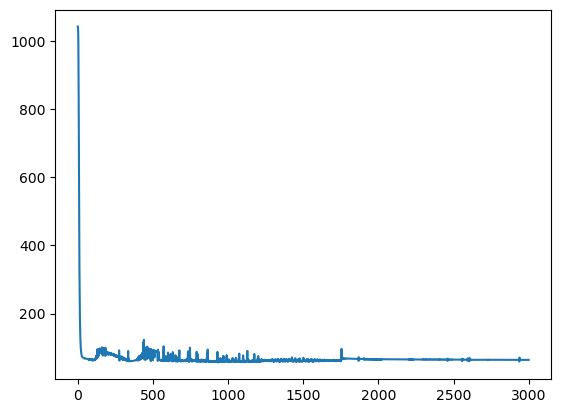

In [69]:
# Plot losses
plt.plot(losses)

In [70]:
# When did lowest losses occur?
min_value = min(losses)
best_epochs = losses.index(min_value)
print('Lowest loss: {} \n Suggested n_epochs: {}'.format(min_value, best_epochs))

Lowest loss: 56.430965423583984 
 Suggested n_epochs: 933


In [71]:
# save the final model
with open(tlmmodelname, 'wb') as fname:
    pickle.dump(globmodel, fname)

# Test Fine-Tuned Model, Quantify Errors, & Plot Results

In [72]:
tlmmodelname = 'finetuned_lyr2_lyrsz2_chglyr2_ep3000_lr4e-03_071923.pkl'

# Load the trained model
with open(tlmmodelname, 'rb') as f:
    tlm = pickle.load(f)

In [73]:
# predict on the test data
pred = tlm(X_test_local, X_test_global).detach().cpu().numpy()
true = Y_test.detach().cpu().numpy()

/home/kalynkearney/miniconda3/envs/ml/lib/python3.11/site-packages/torch/nn/modules/rnn.py:812: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at /opt/conda/conda-bld/pytorch_1682343995622/work/aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


In [74]:
# Get predictions and true values in each direction
X_true = Y_test[:,0:simlength].to('cpu')
Y_true = Y_test[:,simlength:simlength*2].to('cpu')
Z_true = Y_test[:,simlength*2:simlength*3].to('cpu')

X_pred = pred[:,0:simlength]
Y_pred = pred[:,simlength:simlength*2]
Z_pred = pred[:,simlength*2:simlength*3]

# Print shapes of predictions and true values
print(f'X_pred shape: {X_pred.shape}')
print(f'Y_pred shape: {Y_pred.shape}')
print(f'Z_pred shape: {Z_pred.shape}')
print(f'X_true shape: {X_true.shape}')
print(f'Y_true shape: {Y_true.shape}')
print(f'Z_true shape: {Z_true.shape}')

X_pred shape: (9, 204)
Y_pred shape: (9, 204)
Z_pred shape: (9, 204)
X_true shape: torch.Size([9, 204])
Y_true shape: torch.Size([9, 204])
Z_true shape: torch.Size([9, 204])


In [47]:
# Quantify test errors
mse = mean_squared_error(true, pred)
mae = mean_absolute_error(true, pred)
r2 = r2_score(true, pred)


# Print the results
print(f"Mean Squared Error: {mse:.2f}")
print(f"R2 Score: {r2:.2f}")
print(f"Mean Absolute Error Score: {mae:.2f}")

Mean Squared Error: 103.99
R2 Score: -0.35
Mean Absolute Error Score: 6.10


Figure name: LSTM_ParitySubplots_TLModel_KfC96_Test_071923.png
Figure name: LSTM_ParitySubplots_TLModel_NrM10_Test_071923.png
Figure name: LSTM_ParitySubplots_TLModel_RGr10_Test_071923.png


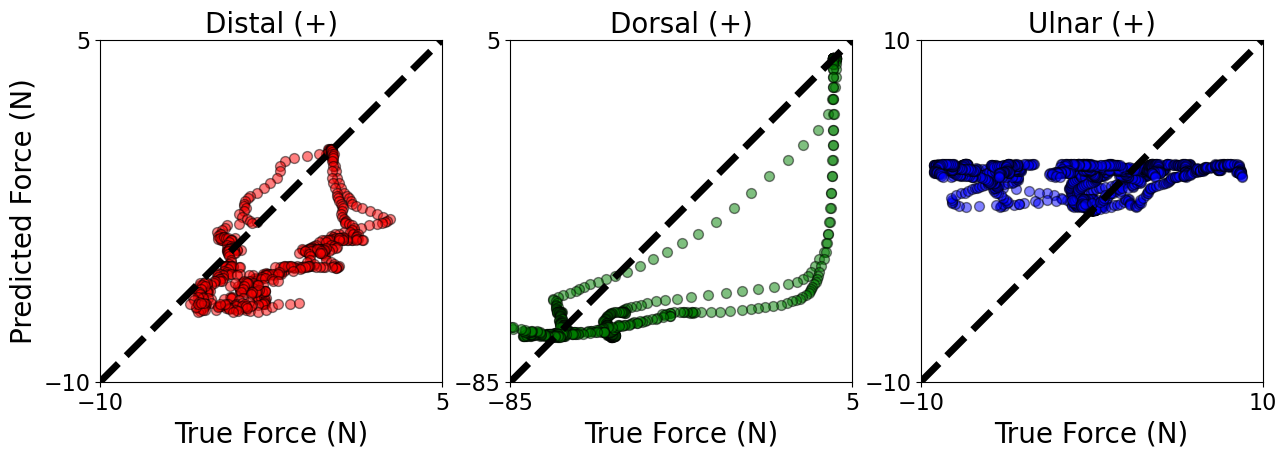

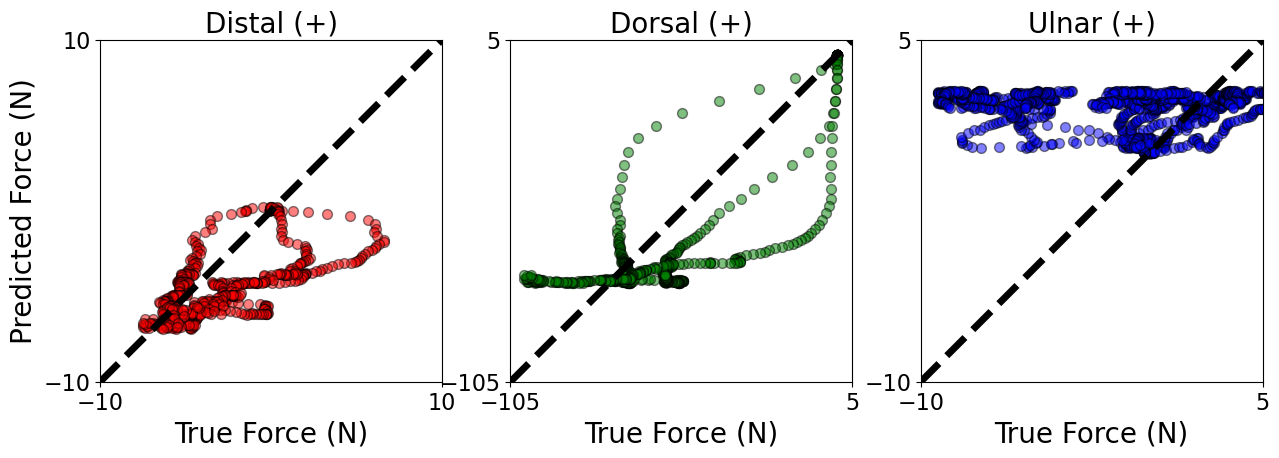

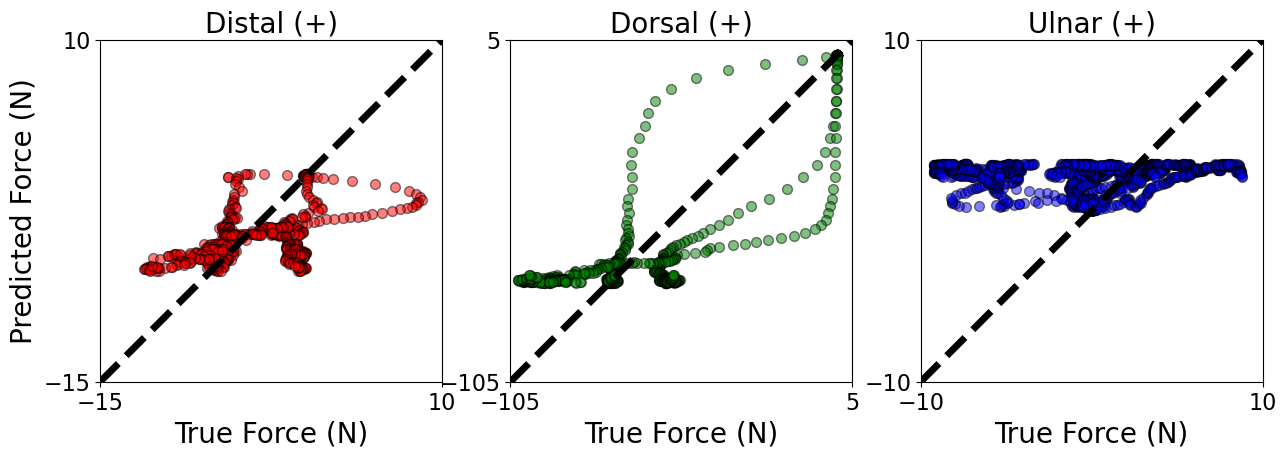

In [50]:

identifier= '_071923'
snum = 0
ntrials = 3
for subj in leave_out_df.Subject.unique():
    # Get data for current subject
    currX_true = X_true[snum:snum+ntrials,:]
    currY_true = Y_true[snum:snum+ntrials,:]
    currZ_true = Z_true[snum:snum+ntrials,:]
    currX_pred = X_pred[snum:snum+ntrials,:]
    currY_pred = Y_pred[snum:snum+ntrials,:]
    currZ_pred = Z_pred[snum:snum+ntrials,:]
    
    # Define figure name
    figname = f'LSTM_ParitySubplots_TLModel_{subj}_Test{identifier}.png'
    print(f'Figure name: {figname}')

    # Parity subplots
    f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15,5))

    # Plot predictions of X 
    ax1.scatter(currX_true, currX_pred, s=50, alpha=0.5, edgecolors='k', color='red')
    ax1.set_title('Distal (+)', fontsize = 20)
    ax1.set_xlabel('True Force (N)', fontsize = 20)
    ax1.set_ylabel('Predicted Force (N)', fontsize = 20)
    ax1.set_aspect('equal')

    # Set min and max range for axes
    alldata = np.concatenate((np.array(currX_true), X_pred), axis=0)
    max_range = roundup(alldata.max())
    min_range = rounddown(alldata.min())
    ax1.set_xlim(min_range, max_range)
    ax1.set_ylim(min_range, max_range)
    ax1.set_xticks([min_range, max_range])
    ax1.set_yticks([min_range, max_range])
    ax1.tick_params(axis='both', which = 'major', labelsize = 16)

    ax1.plot([0, 1], [0, 1], '--k', linewidth=5, transform=ax1.transAxes)



    # Plot predictions of Y
    ax2.scatter(currY_true, currY_pred, s=50, alpha=0.5, edgecolors='k', color = 'green')
    ax2.set_title('Dorsal (+)', fontsize = 20)
    ax2.set_xlabel('True Force (N)', fontsize = 20)
    ax2.set_aspect('equal')

    # Set min and max range for axes
    alldata = np.concatenate((np.array(currY_true), currY_pred), axis=0)
    max_range = roundup(alldata.max())
    min_range = rounddown(alldata.min())
    ax2.set_xlim(min_range, max_range)
    ax2.set_ylim(min_range, max_range)
    ax2.set_xticks([min_range, max_range])
    ax2.set_yticks([min_range, max_range])
    ax2.tick_params(axis='both', which = 'major', labelsize = 16)

    ax2.plot([0, 1], [0, 1], '--k', linewidth=5, transform=ax2.transAxes)

    # Plot predictions of Z
    ax3.scatter(Z_true, Z_pred, s=50, alpha=0.5, edgecolors='k', color = 'blue')
    ax3.set_title('Ulnar (+)', fontsize = 20)
    ax3.set_xlabel('True Force (N)', fontsize = 20)
    ax3.set_aspect('equal')

    # Set min and max range for axes
    alldata = np.concatenate((np.array(currZ_true), currZ_pred), axis=0)
    max_range = roundup(alldata.max())
    min_range = rounddown(alldata.min())
    ax3.set_xlim(min_range, max_range)
    ax3.set_ylim(min_range, max_range)
    ax3.set_xticks([min_range, max_range])
    ax3.set_yticks([min_range, max_range])
    ax3.tick_params(axis='both', which = 'major', labelsize = 16)

    ax3.plot([0, 1], [0, 1], '--k', linewidth=5, transform=ax3.transAxes)
    plt.savefig(figname, dpi = 600)
    
    snum += ntrials
    

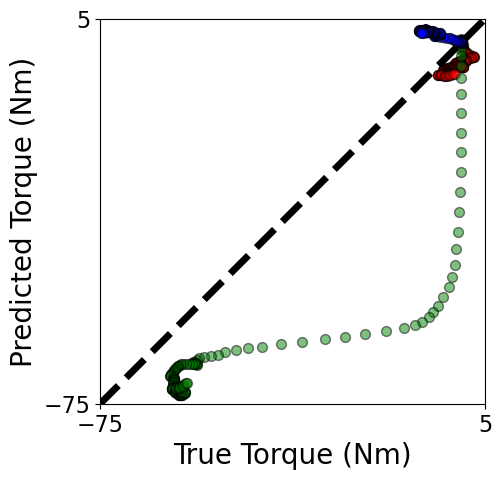

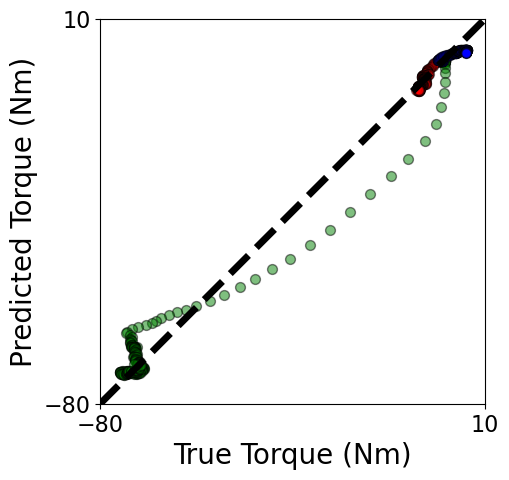

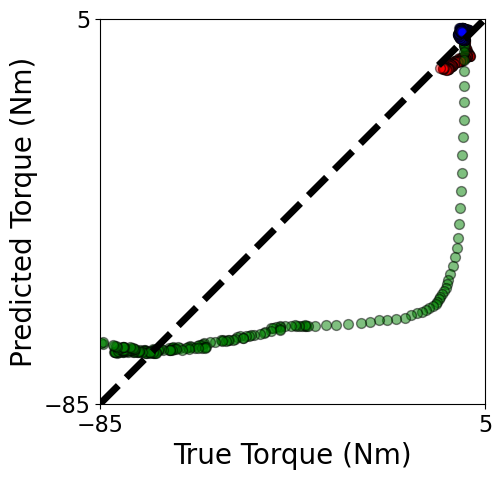

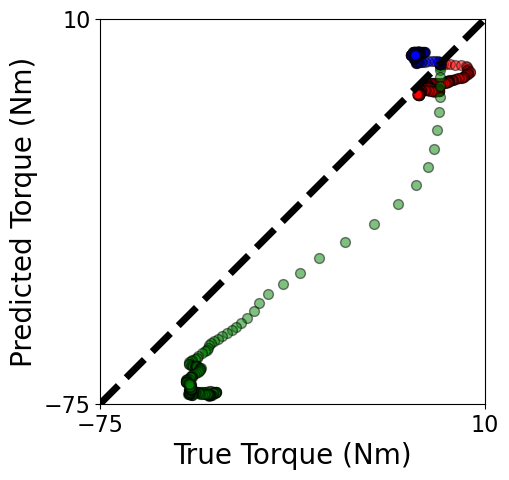

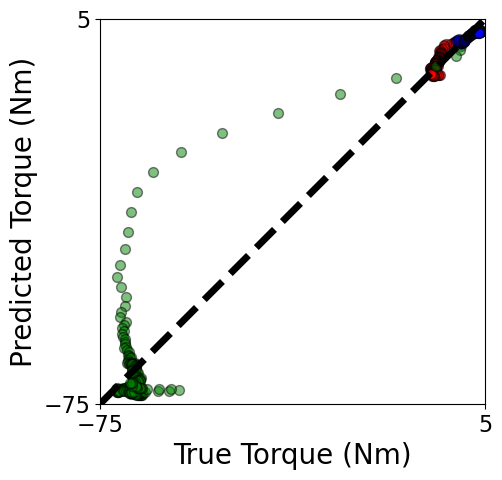

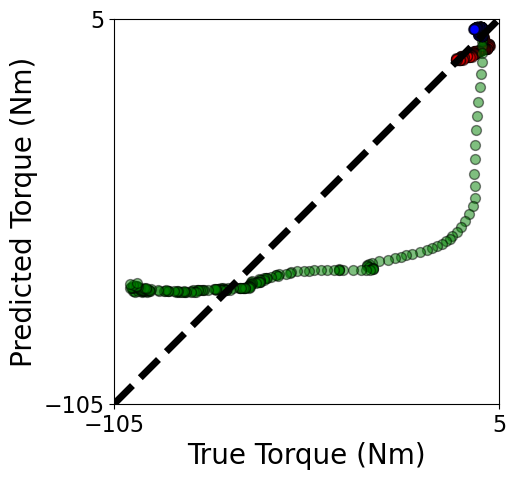

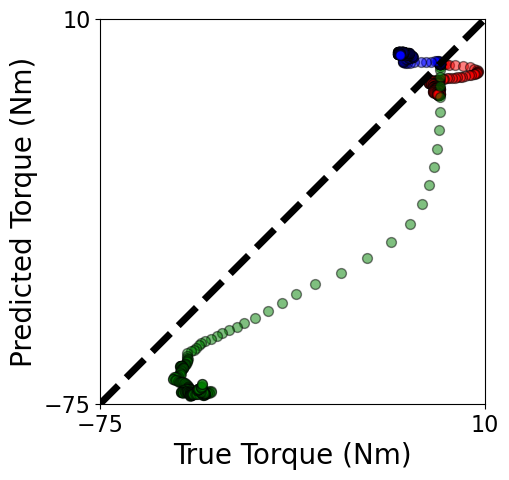

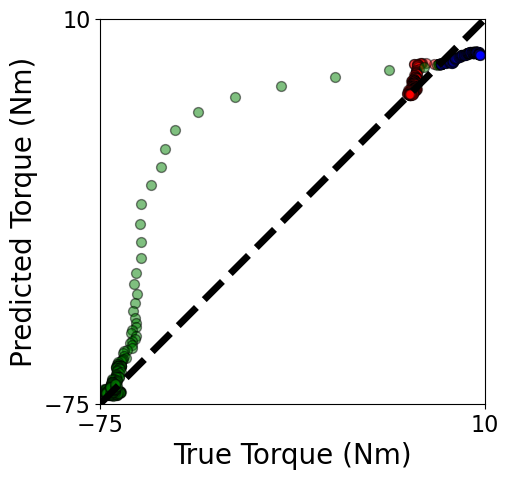

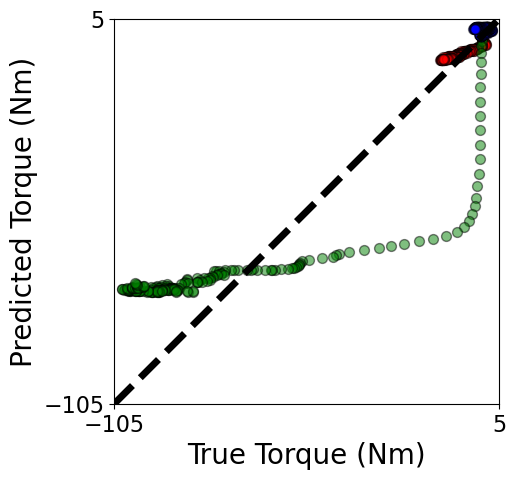

In [51]:
# Plot separate parity plots for each subject

identifier= '_071923'
tnum = 0
ntrials = 3
for subj in leave_out_df.Subject.unique():
    
    for i in range(ntrials):
        # Parity subplots
        f, (ax1) = plt.subplots(1, 1, figsize=(15,5))
        figname = 'LSTM_'+subj+'trial{}_{}.png'.format(i+1, identifier)
        
        # Plot predictions of X 
        ax1.scatter(true[tnum, 0:simlength], pred[tnum, 0:simlength], s=50, alpha=0.5, edgecolors='k', color='red', label='Fx')
        ax1.scatter(true[tnum, simlength:simlength*2], pred[tnum, simlength:simlength*2], s=50, alpha=0.5, edgecolors='k', color='green', label='Fy')
        ax1.scatter(true[tnum, simlength*2:simlength*3], pred[tnum, simlength*2:simlength*3], s=50, alpha=0.5, edgecolors='k', color='blue', label='Fz')
        ax1.set_title('', fontsize = 20)
        ax1.set_xlabel('True Torque (Nm)', fontsize = 20)
        ax1.set_ylabel('Predicted Torque (Nm)', fontsize = 20)
        ax1.set_aspect('equal')

        # Set min and max range for axes
        alldata = np.concatenate((np.array(true[tnum]), pred[tnum]), axis=0)
        max_range = roundup(alldata.max())
        min_range = rounddown(alldata.min())
        ax1.set_xlim(min_range, max_range)
        ax1.set_ylim(min_range, max_range)
        ax1.set_xticks([min_range, max_range])
        ax1.set_yticks([min_range, max_range])
        ax1.tick_params(axis='both', which = 'major', labelsize = 16)

        ax1.plot([0, 1], [0, 1], '--k', linewidth=5, transform=ax1.transAxes)
        
        tnum += 1

        plt.savefig(figname, dpi = 600)
    

# Note to self: Pick up here!!! 

/scratch/local/3344656/ipykernel_119565/469007171.py:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = cm.get_cmap('viridis')


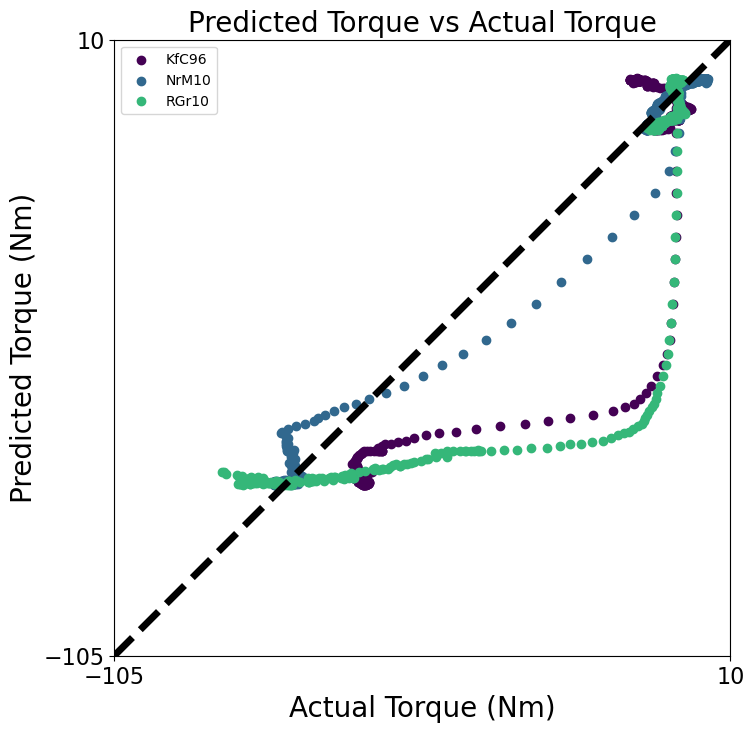

<Figure size 640x480 with 0 Axes>

In [67]:
# Plot parity summarizing all leave out subjects

figname = 'LSTM_AllTestSubjects'+'{}.png'.format(identifier)

# Get unique subjects in the correct order
unique_subjects = leave_out_df.Subject.unique()

# Create a colormap for subjects
colormap = cm.get_cmap('viridis')
num_subjects = len(unique_subjects)
colors = [colormap(i / num_subjects) for i in range(num_subjects)]

# Create a scatter plot with color-coded subjects
plt.figure(figsize=(10, 8))
snum = 0
for i, subject in enumerate(unique_subjects):
    
    plt.scatter(true[snum], pred[snum], color=colors[i], label=subject)
    snum += 1
plt.xlabel('Actual Torque (Nm)', fontsize=20)
plt.ylabel('Predicted Torque (Nm)', fontsize=20)
plt.title('Predicted Torque vs Actual Torque', fontsize=20)

# Set aspect ratio to be equal
plt.gca().set_aspect('equal', adjustable='box')

# Set min and max range for axes
alldata = np.concatenate((np.array(true), pred), axis=0)
max_range = roundup(alldata.max())
min_range = rounddown(alldata.min())
plt.xlim(min_range, max_range)
plt.ylim(min_range, max_range)
plt.xticks([min_range, max_range])
plt.yticks([min_range, max_range])
plt.tick_params(axis='both', which = 'major', labelsize = 16)
plt.plot([0, 1], [0, 1], '--k', linewidth=5, transform=plt.gca().transAxes)

plt.grid(True)
plt.legend()
plt.show()

# Save figure
plt.savefig(figname, dpi = 600)


# Train Recorded-Only Model

In [ ]:
# Get parameters and architecture of best model
n_layers = best_params['layers']
layer_size = best_params['layer_size']
learning_rate = best_params['learning_rate']
weight_decay = best_params['weight_decay']

# Define other model attributes
device = 'cuda'
n_epochs = 3000
batch_size = 4

In [ ]:
# Define train and test set 
leave_out_df = df_normalized[df_normalized['Subject'].isin(leave_out_subj)]
leave_out = Dataset_exp_LSTM(leave_out_df, window_size=window_size_test, stride=stride_test, xcols = xcols, ycols = ycols)
print('Size of X for test set: {}'.format(leave_out.X.shape))
print('Size of Y for test set: {}'.format(leave_out.Y.shape))
print('Trials in test set: {} \n'.format(leave_out.X.shape[0]))

train_df = df_normalized[~df_normalized['Subject'].isin(leave_out_subj)]
train = Dataset_exp_LSTM(train_df,  window_size=window_size, stride=stride, xcols = xcols, ycols = ycols)
print('Size of X for train set: {}'.format(train.X.shape))
print('Size of Y for train set: {}'.format(train.Y.shape))
print('Trials in test set: {} \n'.format(train.X.shape[0]))

print('Subject(s) in test set: {}'.format(leave_out_df['Subject'].unique()))
print('Subjects in training set: {}'.format(train_df['Subject'].unique()))

# get the train and test data
X_train_local = train.X[:,:,:n_local_features].to(device)
X_train_global = train.X[:,:,n_local_features:].to(device)[:,0,:]
Y_train = train.Y.to(device)
X_test_local = leave_out.X[:,:,:n_local_features].to(device)
X_test_global = leave_out.X[:,:,n_local_features:].to(device)[:,0,:]
Y_test = leave_out.Y.to(device)

In [ ]:
# Define architecture for recorded-only model
explstm = lstm(n_inputs=len(xcols_dynamic), hidden_size=ptmodel.hidden_size, n_outputs=ptmodel.output.out_features,
               n_linear_layers=ptmodel.n_linear_layers, layer_size=ptmodel.layer_size).to(device)
explstm(X_train_local)


In [ ]:
# Create the global model using the frozen pretrained model
expglobmodel = global_model(explstm, n_global_inputs=len(xcols_static), layer_size=layer_size, n_layers=n_layers, freeze_ptmodel= False).to(device)
print('Recorded-Only Global Model: {}'.format(expglobmodel))

# Define the optimizer
optimizer = torch.optim.Adam(expglobmodel.parameters(), lr=learning_rate, weight_decay=weight_decay)

# Train the model
losses = run_Pytorch_global(expglobmodel, 
                            X_train_local, 
                            X_train_global, 
                            Y_train,  
                            n_epochs=n_epochs, 
                            learning_rate=learning_rate, 
                            batch_size=batch_size, 
                            device=device,
                            optimizer=optimizer)   

In [ ]:
plt.plot(losses)

In [ ]:
min_value = min(losses)
best_epochs = losses.index(min_value)
print('Lowest loss: {} \n Suggested n_epochs: {}'.format(min_value, best_epochs))

In [ ]:
# save the final model
exponlymodelname = 'exponly_lyr{}_lyrsz{}_ep{}_lr{}_071923.pkl'.format(n_layers, layer_size,n_epochs, "{:.0e}".format(learning_rate))
print(exponlymodelname)

# save the final model
with open(exponlymodelname, 'wb') as fname:
    dill.dump(expglobmodel, fname)




# Test Recorded-Only Model

In [ ]:
# Load the trained model
with open(exponlymodelname, 'rb') as f:
    expmodel = dill.load(f)

In [ ]:
# predict on the test data
pred = expmodel(X_test_local, X_test_global).detach().cpu().numpy()
true = Y_test.detach().cpu().numpy()


In [ ]:
mse = mean_squared_error(true, pred)
mae = mean_absolute_error(true, pred)
r2 = r2_score(true, pred)

# Print the results
print(f"Mean Squared Error: {mse:.2f}")
print(f"R2 Score: {r2:.2f}")
print(f"Mean Absolute Error Score: {mae:.2f}")

In [ ]:
identifier= '_RecordedOnly_071923'
snum = 0
for subj in leave_out_df.Subject.unique():
    figname = 'LSTM_'+subj+'{}.png'.format(identifier)

    # Parity subplots
    f, (ax1) = plt.subplots(1, 1, figsize=(15,5))

    # Plot predictions of X 
    ax1.scatter(true[snum], pred[snum], s=50, alpha=0.5, edgecolors='k', color='red')
    ax1.set_title('', fontsize = 20)
    ax1.set_xlabel('True Torque (Nm)', fontsize = 20)
    ax1.set_ylabel('Predicted Torque (Nm)', fontsize = 20)
    ax1.set_aspect('equal')

    # Set min and max range for axes
    alldata = np.concatenate((np.array(true[snum]), pred[snum]), axis=0)
    max_range = roundup(alldata.max())
    min_range = rounddown(alldata.min())
    ax1.set_xlim(min_range, max_range)
    ax1.set_ylim(min_range, max_range)
    ax1.set_xticks([min_range, max_range])
    ax1.set_yticks([min_range, max_range])
    ax1.tick_params(axis='both', which = 'major', labelsize = 16)

    ax1.plot([0, 1], [0, 1], '--k', linewidth=5, transform=ax1.transAxes)
    
    snum += 1

    plt.savefig(figname, dpi = 600)
    

In [ ]:
figname = 'LSTM_AllTestSubjects'+'{}.png'.format(identifier)

# Get unique subjects in the correct order
unique_subjects = leave_out_df.Subject.unique()

# Create a colormap for subjects
colormap = cm.get_cmap('viridis')
num_subjects = len(unique_subjects)
colors = [colormap(i / num_subjects) for i in range(num_subjects)]

# Create a scatter plot with color-coded subjects
plt.figure(figsize=(10, 8))
snum = 0
for i, subject in enumerate(unique_subjects):
    
    plt.scatter(true[snum], pred[snum], color=colors[i], label=subject)
    snum += 1
plt.xlabel('Actual Torque (Nm)', fontsize=20)
plt.ylabel('Predicted Torque (Nm)', fontsize=20)
plt.title('Predicted Torque vs Actual Torque', fontsize=20)

# Set aspect ratio to be equal
plt.gca().set_aspect('equal', adjustable='box')

# Set min and max range for axes
alldata = np.concatenate((np.array(true), pred), axis=0)
max_range = roundup(alldata.max())
min_range = rounddown(alldata.min())
plt.xlim(min_range, max_range)
plt.ylim(min_range, max_range)
plt.xticks([min_range, max_range])
plt.yticks([min_range, max_range])
plt.tick_params(axis='both', which = 'major', labelsize = 16)
plt.plot([0, 1], [0, 1], '--k', linewidth=5, transform=plt.gca().transAxes)

plt.grid(True)
plt.legend()
plt.show()

# Save figure
plt.savefig(figname, dpi = 600)


In [ ]:
snum = 0
for subj in leave_out_df.Subject.unique():
    figname = 'LSTM_Sample_'+subj+'{}.png'.format(identifier)
    start = 0
    end = simlength

    time = leave_out_df['Time'][0:end]
    f, ax = plt.subplots(1, 1)
    xpred = ax.plot(time, pred[snum], color = 'blue', label = 'Predicted')
    xtrue = ax.plot(time, true[snum], color = 'black', label = 'True')

    ax.legend()
    ax.set_xlabel('Time (s)', fontsize = 16)
    ax.set_ylabel('Torque (Nm)', fontsize = 16)

    # Set title to subj
    ax.set_title(subj, fontsize = 20)
    plt.savefig(figname, dpi = 600)
    
    snum += 1